# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

19:05:09 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=648674;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=811945;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=285513;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=760611;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

19:06:09 INFO      Auto-determined polynomial order: 0                                ]8;id=417526;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=408138;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

19:06:18 INFO      None 0-order polynomial fit with the mle method                               ]8;id=69657;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=72492;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=980220;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=733026;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=711623;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484171;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=642302;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=15416;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=335645;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=256516;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=730095;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=206333;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=296632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=663636;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=998901;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=230220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=180064;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=965529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

19:06:21 INFO      Now using 120 bins                                                          ]8;id=216485;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=737395;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

19:06:23 INFO      Auto-determined polynomial order: 1                                ]8;id=711506;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=794126;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

19:06:33 INFO      None 1-order polynomial fit with the mle method                               ]8;id=637939;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=981648;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=274589;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=812074;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=943641;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=477385;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=374018;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=776542;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=719382;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=797640;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

19:06:34 INFO      Auto-probed noise models:                                                    ]8;id=694231;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=765205;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=68048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=889838;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=14700;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=282492;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=40978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=386863;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=462609;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

19:06:35 INFO      Auto-determined polynomial order: 1                                ]8;id=804603;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=198627;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

19:06:45 INFO      None 1-order polynomial fit with the mle method                               ]8;id=396493;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=312377;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=570504;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=576166;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=67961;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=711177;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

19:06:46 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=662905;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=223525;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=97984;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=393880;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=751875;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=174409;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=958632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=325136;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=129430;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=106530;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=639539;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=96419;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=736005;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=10524;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

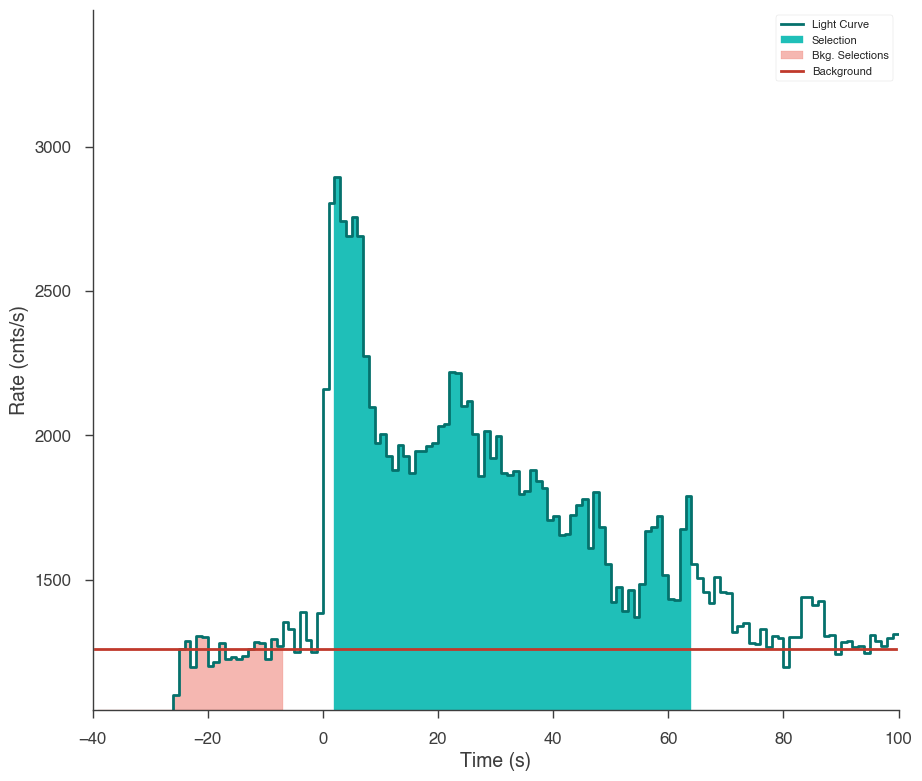

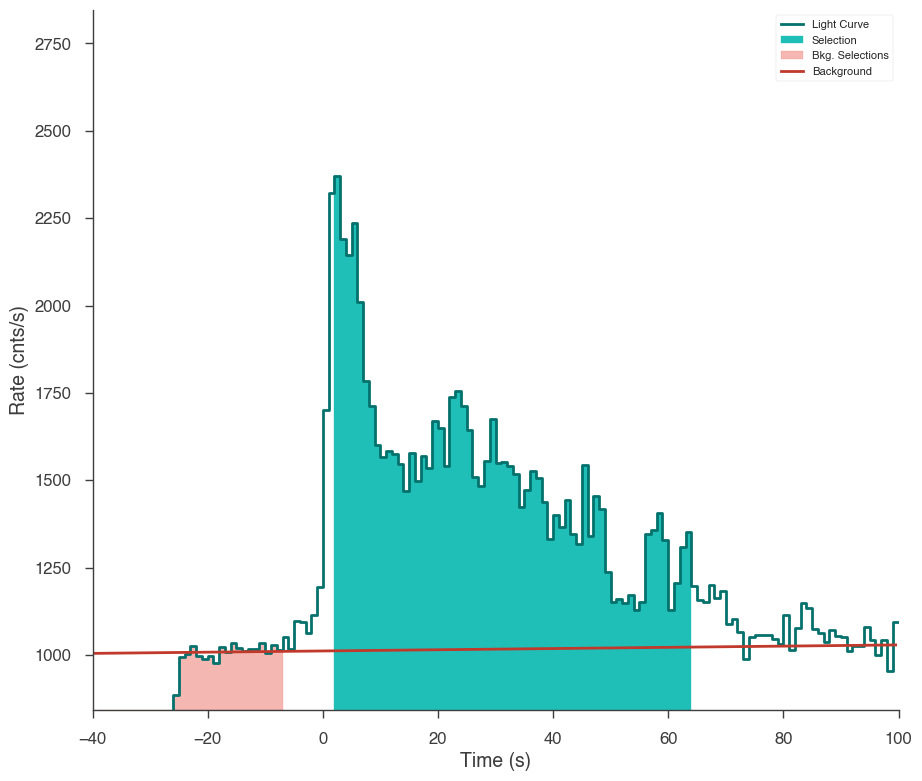

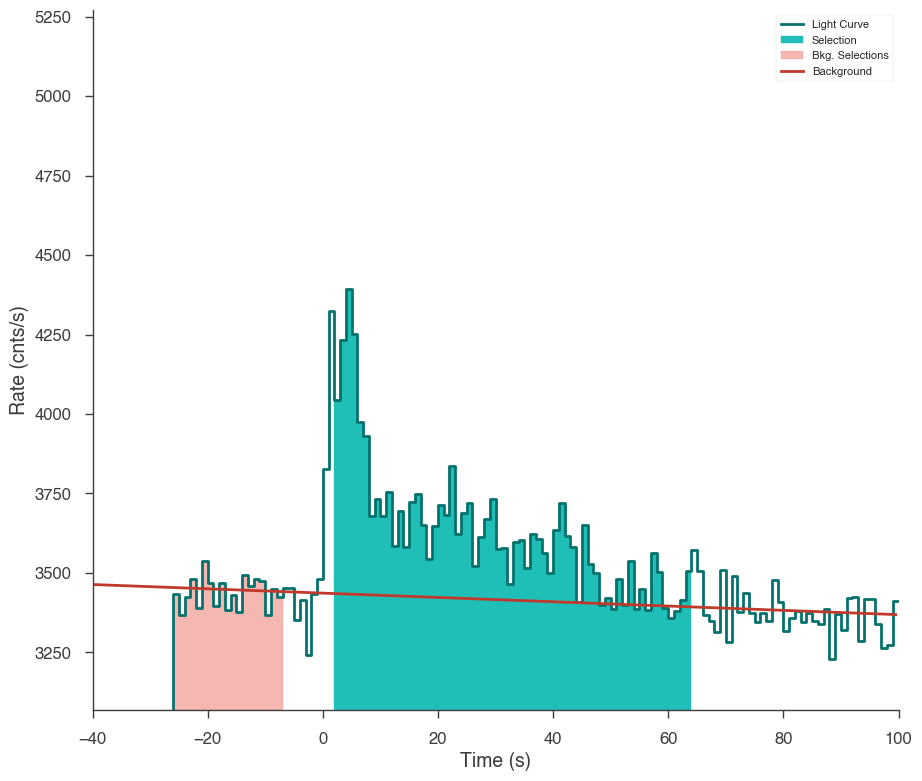

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):
        fluence_plugin.set_active_measurements("250-30000")

    else:
        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

19:06:47 INFO      sampler set to multinest                                                ]8;id=522158;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=839070;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

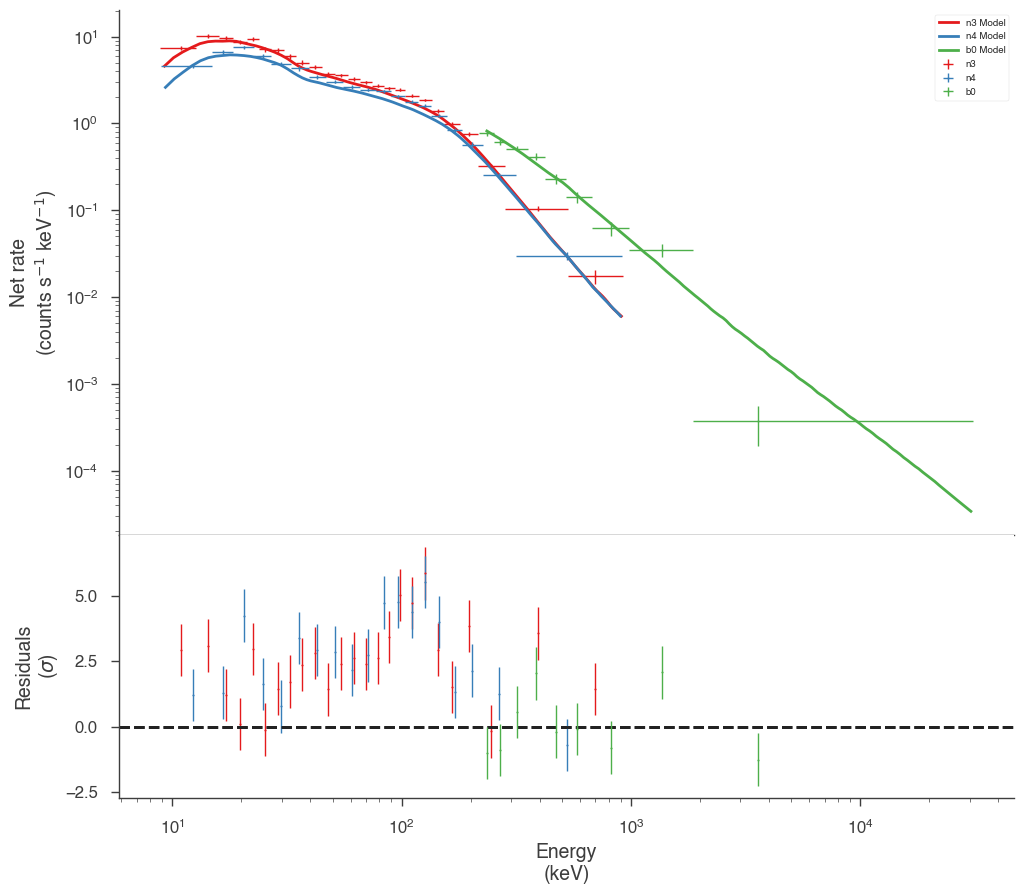

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.3762014130380      +/-  0.22493272010548993     
 Total Likelihood Evaluations:        22844
 Sampling finished. Exiting MultiNest



19:07:04 INFO      fit restored to maximum of posterior                                         ]8;id=202241;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=83789;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=996492;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=431746;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.448 +0.004 +0.04) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.101 +0.006 +0.04,
GRB080916009...break_energy,(1.95 +0.04 +0.6) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.6 +3.3) x 10^-1,
GRB080916009...beta,-1.981 -0.19 -0.021,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1049.933729
n3,-1018.908755
n4,-1011.465352
total,-3080.307836


Values of statistical measures:

,statistical measures
AIC,6170.786127
BIC,6190.018338
DIC,6179.641409
PDIC,4.329545
log(Z),-1346.910571


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=934022;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=681596;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

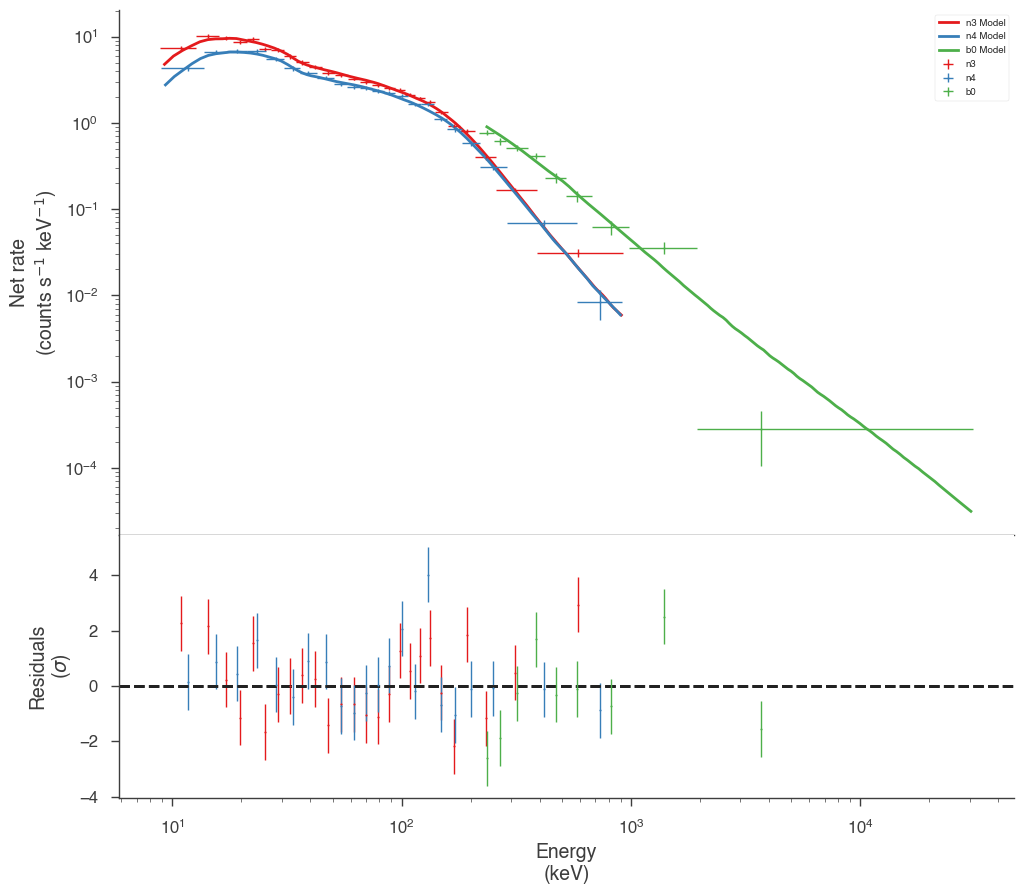

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

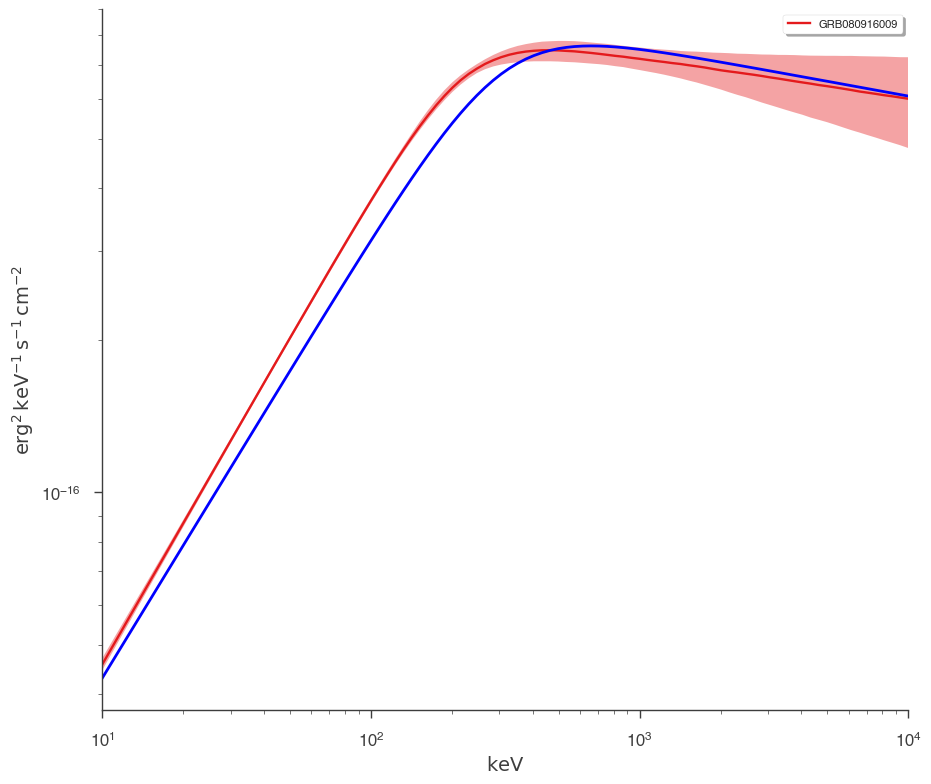

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

19:09:06 INFO      Created 15 bins via bayesblocks                                       ]8;id=844961;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=203958;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


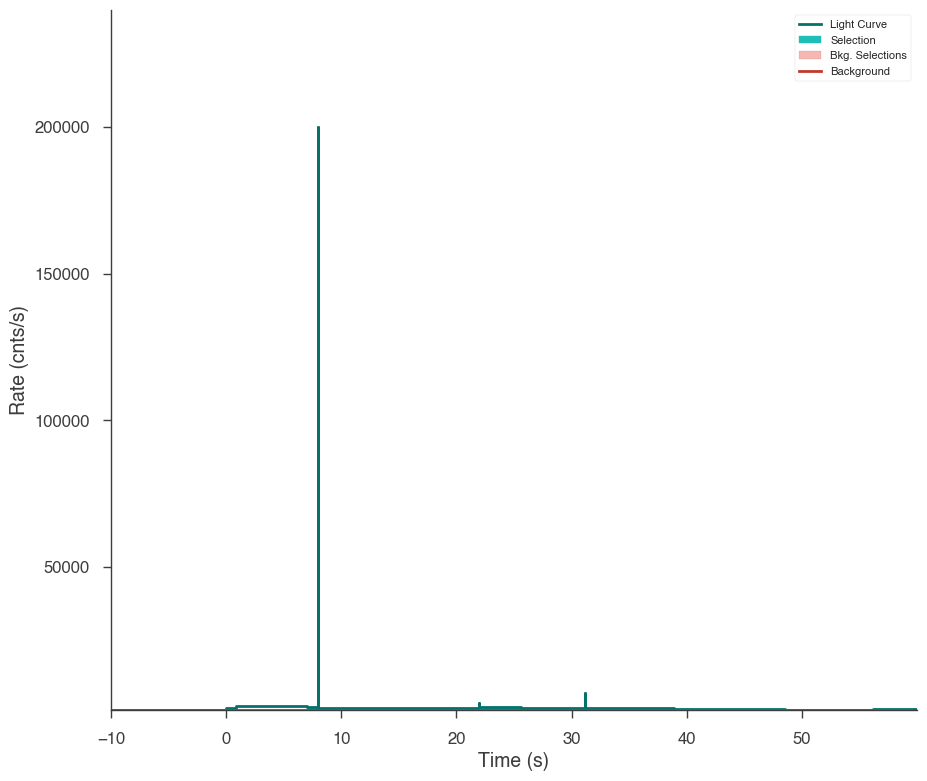

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):
    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=758780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=291381;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

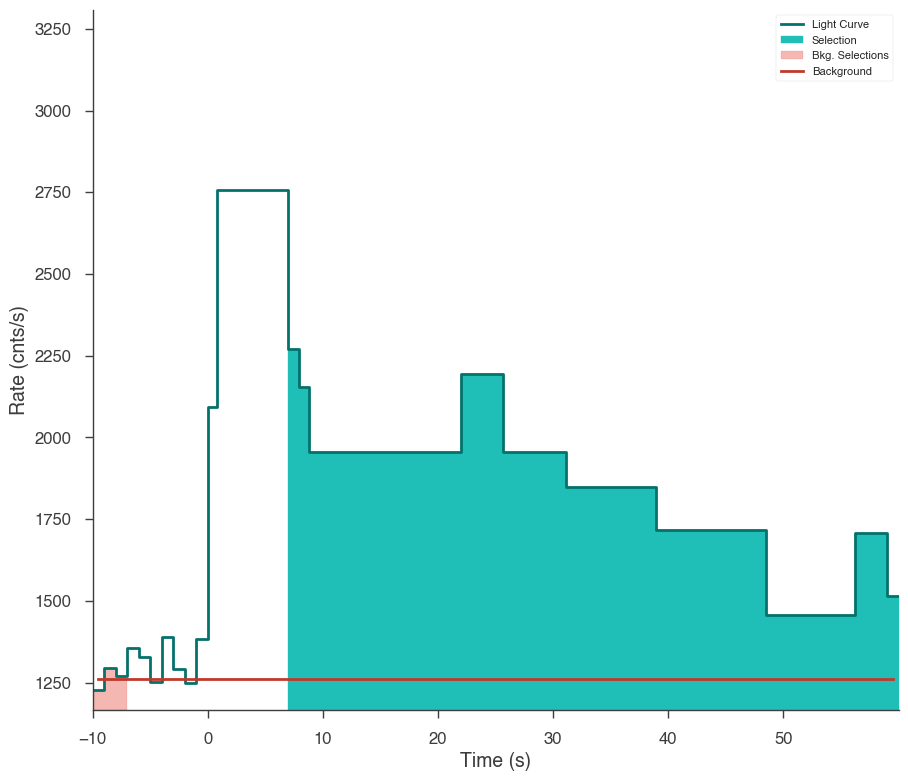

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=635512;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=347551;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

19:09:07 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=849350;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=906832;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=501586;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=258429;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=911536;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=218500;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=978266;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=933407;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

19:09:08 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=218263;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=455111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):
    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=232822;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=696985;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=590847;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=71622;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=170966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=798768;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=630514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=70646;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=255708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=276555;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 107 bins                                                          ]8;id=71763;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=715532;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=112544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=127482;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -789.30687563973970      +/-  0.18273650717895826     
 Total Likelihood Evaluations:        15701
 Sampling finished. Exiting MultiNest



19:09:21 INFO      fit restored to maximum of posterior                                         ]8;id=513402;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=660852;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=812629;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=701319;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.50 -0.5 +0.27) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.7 -1.3 +0.7) x 10^-1,
grb.spectrum.main.Band.xp,(3.24 -0.29 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.075 -0.31 +0.031,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.679243
n3_interval0,-250.290154
n4_interval0,-268.081333
total,-804.050730


Values of statistical measures:

,statistical measures
AIC,1616.214774
BIC,1631.623592
DIC,1569.550227
PDIC,1.894588
log(Z),-342.791621


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=575552;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=583347;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=920539;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=991319;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=316142;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=403214;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=666678;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=30323;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=530827;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=274666;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=957143;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=188143;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=849113;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=881020;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1943.1774372081893      +/-  0.21253695526133976     
 Total Likelihood Evaluations:        23293
 Sampling finished. Exiting MultiNest



19:09:37 INFO      fit restored to maximum of posterior                                         ]8;id=942779;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=419995;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=99195;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=785690;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.12 -0.16 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.61 -0.30 +0.25) x 10^-1,
grb.spectrum.main.Band.xp,(6.3 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.15 -0.11 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-673.936424
n3_interval1,-641.814412
n4_interval1,-645.518713
total,-1961.269549


Values of statistical measures:

,statistical measures
AIC,3930.652412
BIC,3946.061230
DIC,3873.434313
PDIC,3.671057
log(Z),-843.911238


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=753525;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=590563;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=523646;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=334908;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=622747;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=677515;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=800058;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=578820;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=995249;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=606626;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 115 bins                                                          ]8;id=161121;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=909115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=851025;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=622954;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -905.62960062608363      +/-  0.19228008077208475     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        20954
 Sampling finished. Exiting MultiNest


19:09:52 INFO      fit restored to maximum of posterior                                         ]8;id=308519;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=520458;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=580028;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=354525;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.52 -0.24 +0.18) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.05 -0.08 +0.05,
grb.spectrum.main.Band.xp,(6.0 -1.1 +3.2) x 10^2,keV
grb.spectrum.main.Band.beta,-1.858 -0.5 +0.031,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.569768
n3_interval2,-289.093581
n4_interval2,-312.614853
total,-926.278201


Values of statistical measures:

,statistical measures
AIC,1860.669717
BIC,1876.078535
DIC,1805.351640
PDIC,2.668523
log(Z),-393.309938


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=917447;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322845;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=801966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=739391;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=231627;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=389529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=316960;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=415299;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=322529;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=820331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 109 bins                                                          ]8;id=343696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=156159;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=340290;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=138188;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.55525361764330      +/-  0.17788892654854577     
 Total Likelihood Evaluations:        16458
 Sampling finished. Exiting MultiNest



19:10:03 INFO      fit restored to maximum of posterior                                         ]8;id=57006;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=683749;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=685507;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=749686;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.90 -0.26 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.2 -0.8 +1.2) x 10^-1,
grb.spectrum.main.Band.xp,(3.4 -0.7 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.4 +0.13,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.397733
n3_interval3,-242.547871
n4_interval3,-262.647355
total,-803.592959


Values of statistical measures:

,statistical measures
AIC,1615.299232
BIC,1630.708050
DIC,1570.033134
PDIC,2.662619
log(Z),-342.465195


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=362609;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=967145;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=585268;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=270646;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=514194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=76028;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=93151;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=487038;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=727269;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=127902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=518962;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=848732;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

19:10:04 INFO      sampler set to multinest                                                ]8;id=140555;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=849616;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2273.4040084066037      +/-  0.21101261243947195     
 Total Likelihood Evaluations:        20293
 Sampling finished. Exiting MultiNest



19:10:16 INFO      fit restored to maximum of posterior                                         ]8;id=239451;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=215778;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=727379;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=672278;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.94 -0.09 +0.04) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.0154 -0.04 -0.0011,
grb.spectrum.main.Band.xp,(4.54 -0.20 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.058 -0.06 +0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-779.279466
n3_interval4,-756.900548
n4_interval4,-748.181924
total,-2284.361938


Values of statistical measures:

,statistical measures
AIC,4576.837190
BIC,4592.246008
DIC,4528.726335
PDIC,2.870221
log(Z),-987.326816


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=112520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=305898;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=225281;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=164197;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=410830;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=339896;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=315608;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=280497;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=902246;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=86299;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=738296;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=630886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=831819;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=837922;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1586.2922186007427      +/-  0.22029864887117645     
 Total Likelihood Evaluations:        19929
 Sampling finished. Exiting MultiNest



19:10:29 INFO      fit restored to maximum of posterior                                         ]8;id=514072;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=918196;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=512175;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=379482;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.66 -0.06 +0.21) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.026 -0.019 +0.04,
grb.spectrum.main.Band.xp,(4.5 -0.7 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.028 -0.024 +0.021,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-537.287812
n3_interval5,-523.683825
n4_interval5,-534.632721
total,-1595.604358


Values of statistical measures:

,statistical measures
AIC,3199.322030
BIC,3214.730848
DIC,3148.705958
PDIC,1.372761
log(Z),-688.917957


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=169415;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=428481;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=558666;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=895014;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=277987;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=849987;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=16582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=610280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=324906;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=980131;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=273958;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=239998;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=126201;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=212299;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.1699489048515      +/-  0.19145559376126250     
 Total Likelihood Evaluations:        19999
 Sampling finished. Exiting MultiNest



19:10:42 INFO      fit restored to maximum of posterior                                         ]8;id=859020;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=682595;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=166374;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=749979;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.95 -0.11 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.01 +/- 0.05,
grb.spectrum.main.Band.xp,(4.5 -0.6 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.35 -0.4 +0.18,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.588852
n3_interval6,-584.293263
n4_interval6,-576.851581
total,-1770.733696


Values of statistical measures:

,statistical measures
AIC,3549.580706
BIC,3564.989523
DIC,3501.332978
PDIC,3.449172
log(Z),-762.260624


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=211383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=374502;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=488854;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=306662;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=874952;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=714819;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=280212;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=321109;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=559537;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=130925;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=668830;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=930494;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=432576;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=464444;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1940.2324014188302      +/-  0.19462594923547516     
 Total Likelihood Evaluations:        19447
 Sampling finished. Exiting MultiNest



19:10:56 INFO      fit restored to maximum of posterior                                         ]8;id=380057;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=467431;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=819628;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=185976;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.68 -0.08 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 +/- 0.05,
grb.spectrum.main.Band.xp,(4.2 -0.6 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.25 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.184205
n3_interval7,-640.869548
n4_interval7,-650.262080
total,-1953.315833


Values of statistical measures:

,statistical measures
AIC,3914.744980
BIC,3930.153797
DIC,3868.538977
PDIC,3.230403
log(Z),-842.632226


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=729463;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=68886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=438382;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=782522;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=302847;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=325349;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=582568;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=840554;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=735858;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=197939;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=950477;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=642378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

19:10:57 INFO      sampler set to multinest                                                ]8;id=738900;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=112666;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2065.0946419385155      +/-  0.20214912683861269     
 Total Likelihood Evaluations:        18580
 Sampling finished. Exiting MultiNest



19:11:10 INFO      fit restored to maximum of posterior                                         ]8;id=296381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=475520;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=378413;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=727796;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.73 -0.28 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.3 -1.4 +2.3) x 10^-1,
grb.spectrum.main.Band.xp,(2.9 -0.7 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-1.946 -0.018 +0.12,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-701.977439
n3_interval8,-700.400561
n4_interval8,-666.953519
total,-2069.331520


Values of statistical measures:

,statistical measures
AIC,4146.776354
BIC,4162.185171
DIC,4104.377550
PDIC,-3.833271
log(Z),-896.859208


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=8947;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=629412;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=40102;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=670633;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=117332;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=394135;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=497191;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=641773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=743874;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=221501;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=318391;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=633629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=191193;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=376665;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.6746028891785      +/-  0.14421814639526226     
 Total Likelihood Evaluations:        12709
 Sampling finished. Exiting MultiNest



19:11:20 INFO      fit restored to maximum of posterior                                         ]8;id=702086;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=352806;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=435478;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=314391;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.12 -0.34 +1.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -1.8 +4) x 10^-1,
grb.spectrum.main.Band.xp,(1.2 -0.5 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.88 -0.33 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.518730
n3_interval9,-617.086186
n4_interval9,-616.346238
total,-1881.951155


Values of statistical measures:

,statistical measures
AIC,3772.015624
BIC,3787.424441
DIC,3667.496644
PDIC,-79.762542
log(Z),-815.898013


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=678288;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=755331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=941792;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=461542;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=323121;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=561917;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=902085;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945041;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=636828;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=390971;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=710547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=713851;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=236083;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=596422;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.2252517439463      +/-  0.16774808524024179     
 Total Likelihood Evaluations:        15781
 Sampling finished. Exiting MultiNest



19:11:31 INFO      fit restored to maximum of posterior                                         ]8;id=11989;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=968404;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=226027;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=175623;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.1 -0.4 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.3 -1.4 +1.3) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 -0.4 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-1.96 -0.23 +0.12,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.782362
n3_interval10,-437.750305
n4_interval10,-433.154327
total,-1331.686993


Values of statistical measures:

,statistical measures
AIC,2671.487301
BIC,2686.896119
DIC,2634.494706
PDIC,1.167190
log(Z),-574.235131


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=335394;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=290151;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=424878;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=257632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=585139;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=589046;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=970896;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=747534;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=794117;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=831117;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=932691;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=261994;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=819281;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=298219;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -811.56203776105895      +/-  0.14451891575452999     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        12621
 Sampling finished. Exiting MultiNest


19:11:41 INFO      fit restored to maximum of posterior                                         ]8;id=242982;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=539148;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=100908;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=356259;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.7 -0.7 +2.2) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.1 -1.9 +3.4) x 10^-1,
grb.spectrum.main.Band.xp,(1.34 -0.33 +0.25) x 10^2,keV
grb.spectrum.main.Band.beta,-2.17 -0.4 +0.24,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.451295
n3_interval11,-272.650700
n4_interval11,-255.731422
total,-820.833418


Values of statistical measures:

,statistical measures
AIC,1649.780150
BIC,1665.188968
DIC,1617.207002
PDIC,-0.038234
log(Z),-352.456915


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=856414;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=685118;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:42 INFO      fit restored to median of posterior                                          ]8;id=571547;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=796602;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:43 INFO      fit restored to median of posterior                                          ]8;id=409532;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=801155;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:44 INFO      fit restored to median of posterior                                          ]8;id=757624;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=399266;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:45 INFO      fit restored to median of posterior                                          ]8;id=65977;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=538290;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:46 INFO      fit restored to median of posterior                                          ]8;id=968697;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=589584;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=405630;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=689360;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:47 INFO      fit restored to median of posterior                                          ]8;id=441401;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=402762;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:48 INFO      fit restored to median of posterior                                          ]8;id=676680;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=983565;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:49 INFO      fit restored to median of posterior                                          ]8;id=857603;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=376674;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=564655;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=762564;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

19:11:50 INFO      fit restored to median of posterior                                          ]8;id=192203;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=307093;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

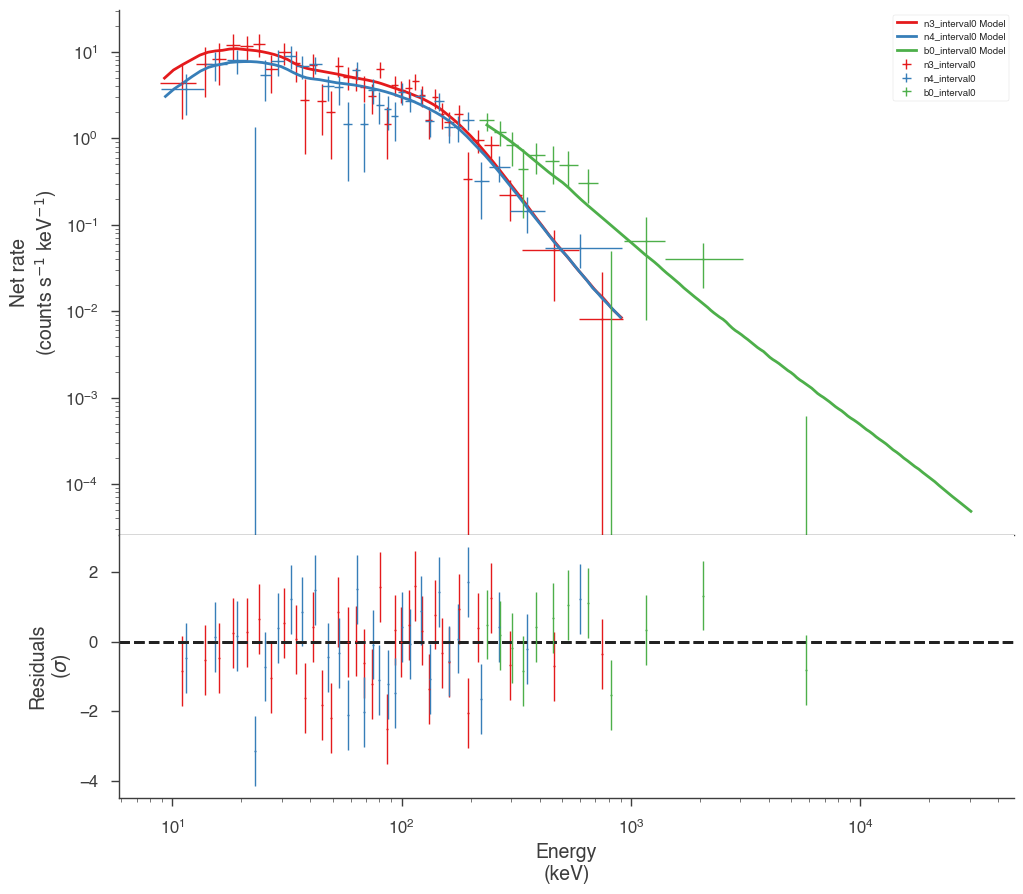

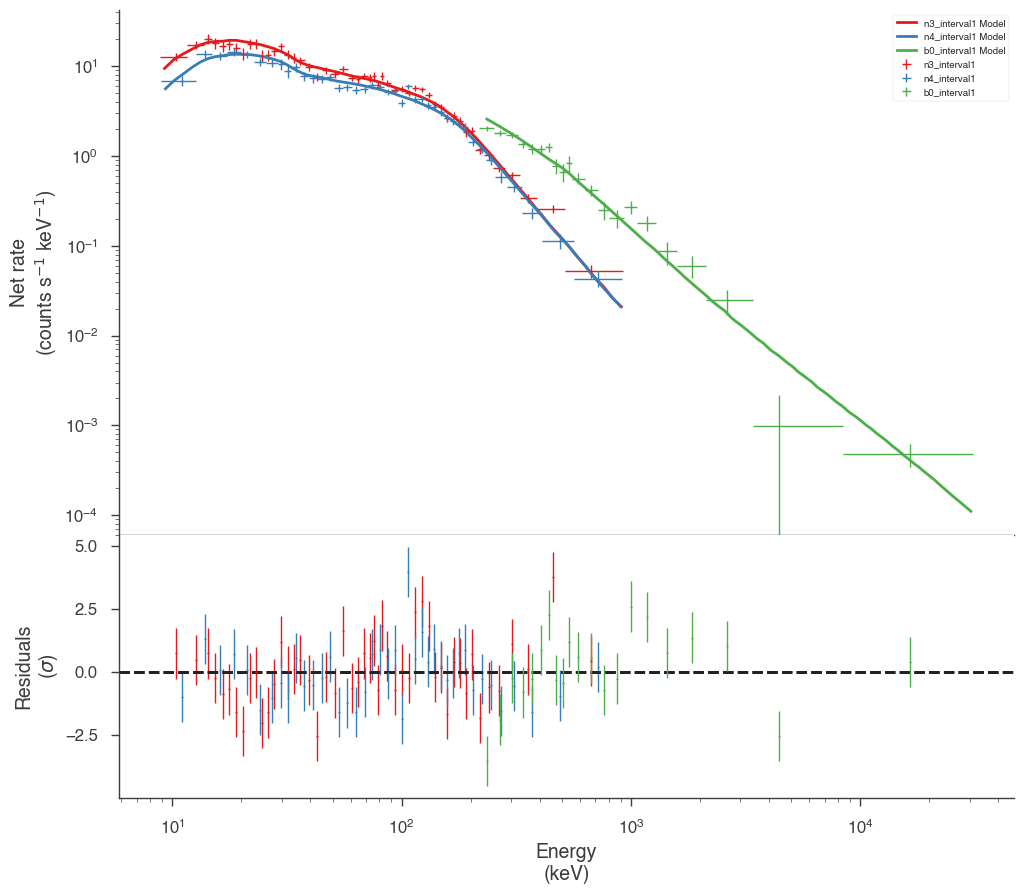

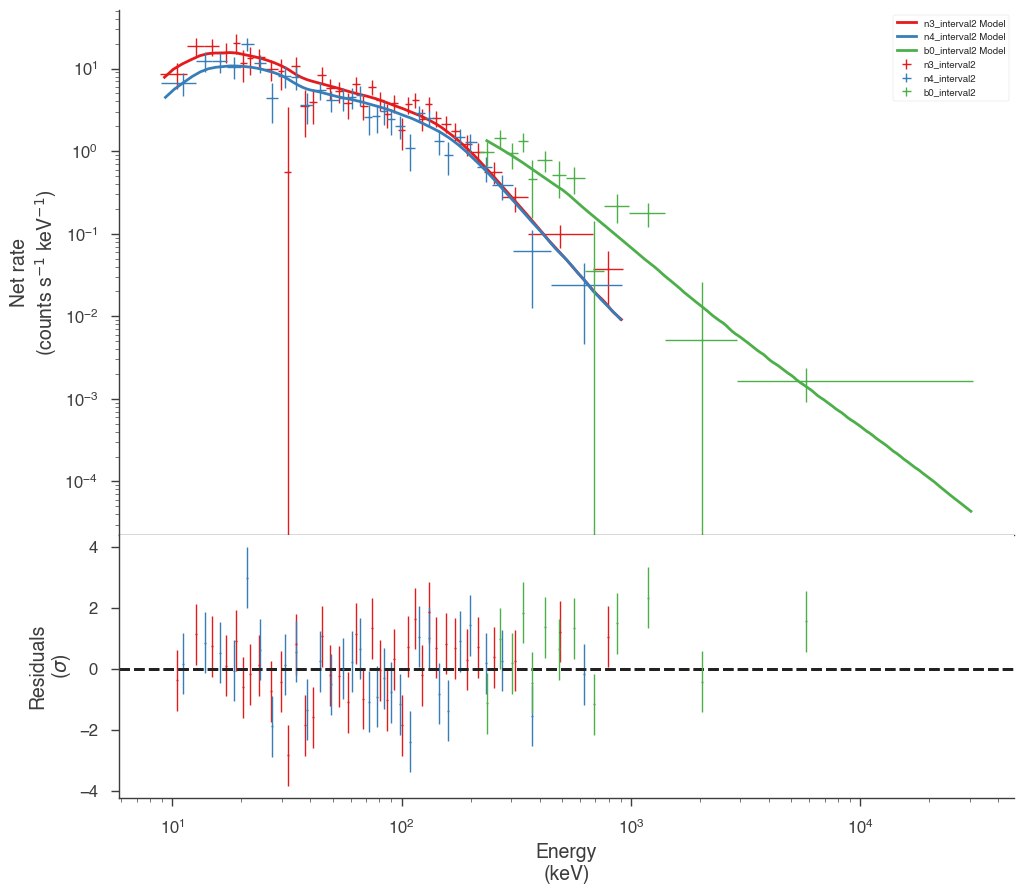

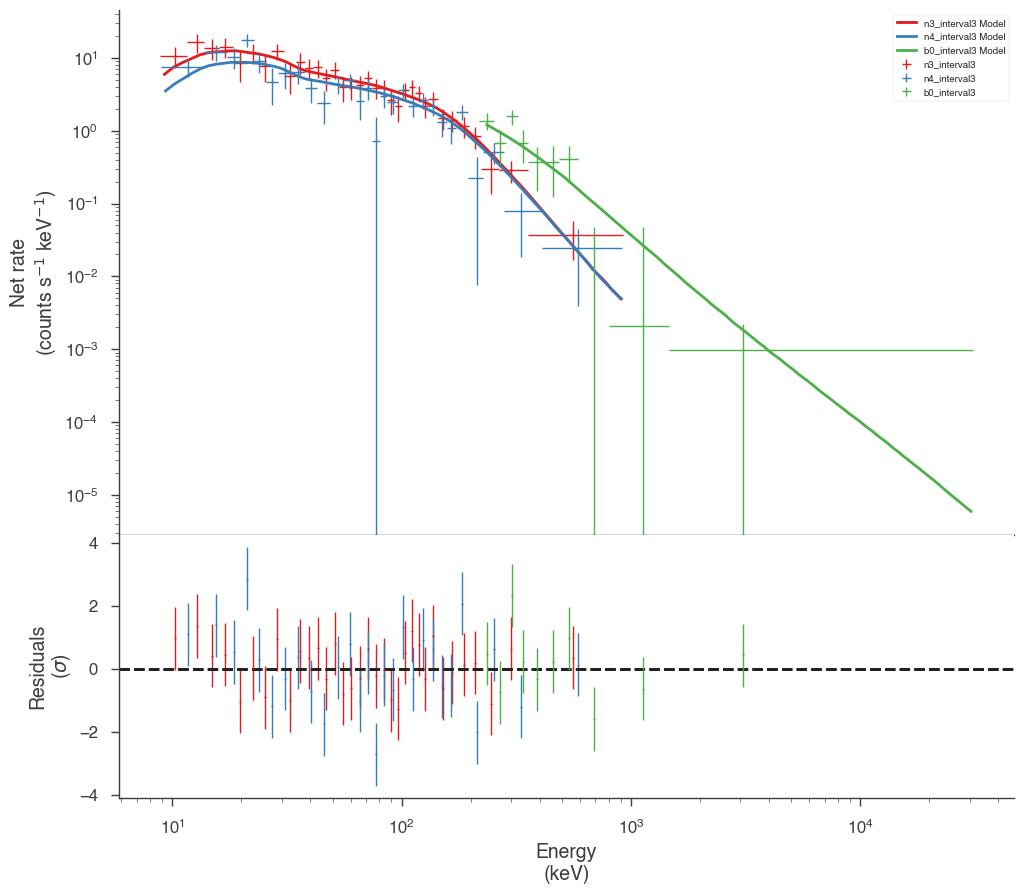

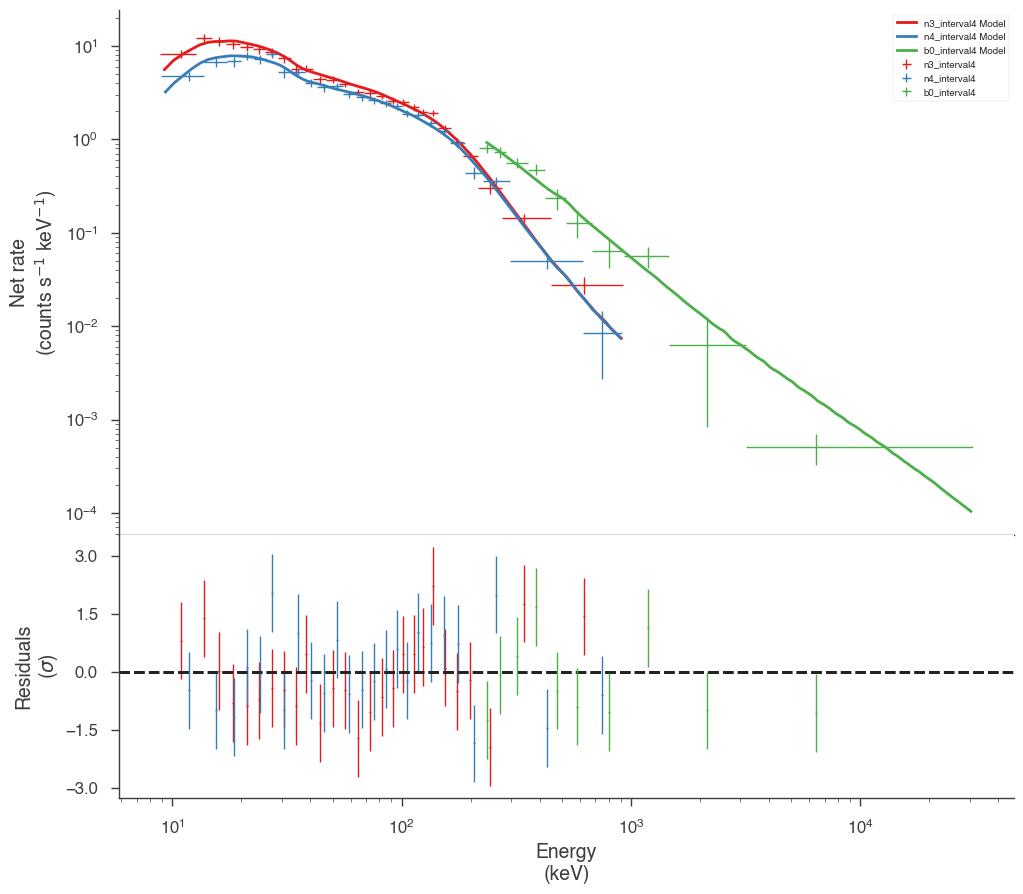

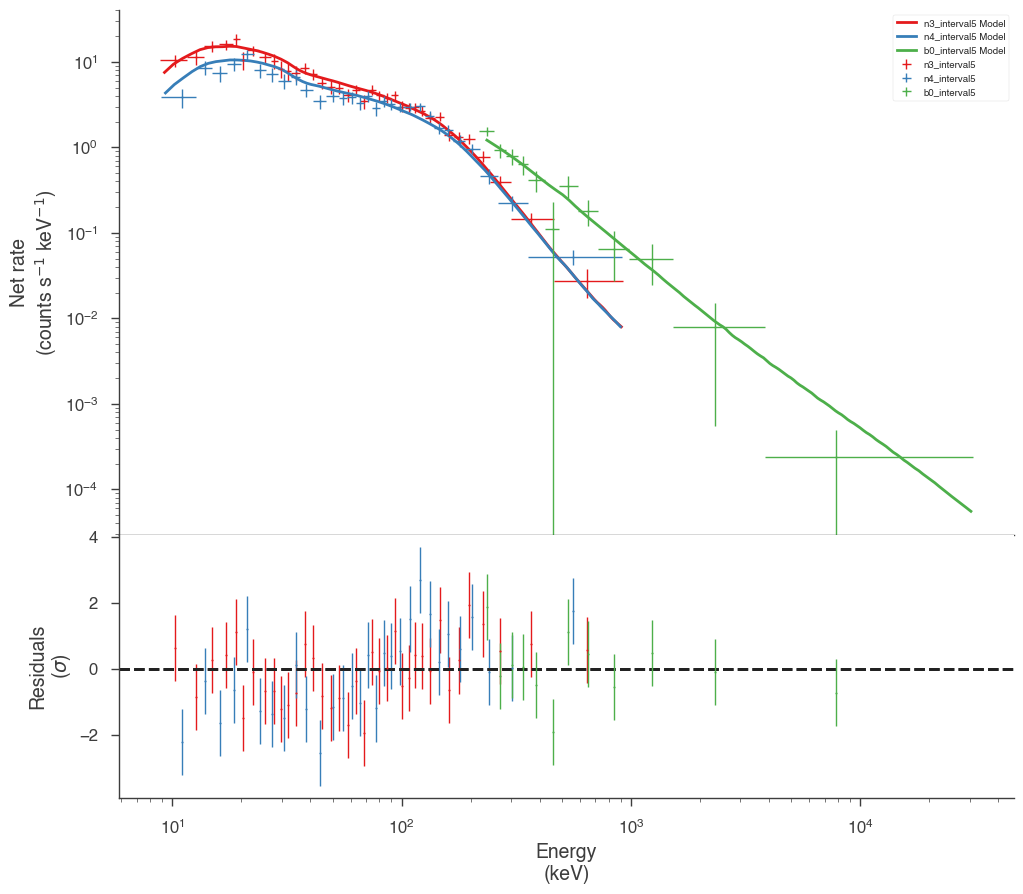

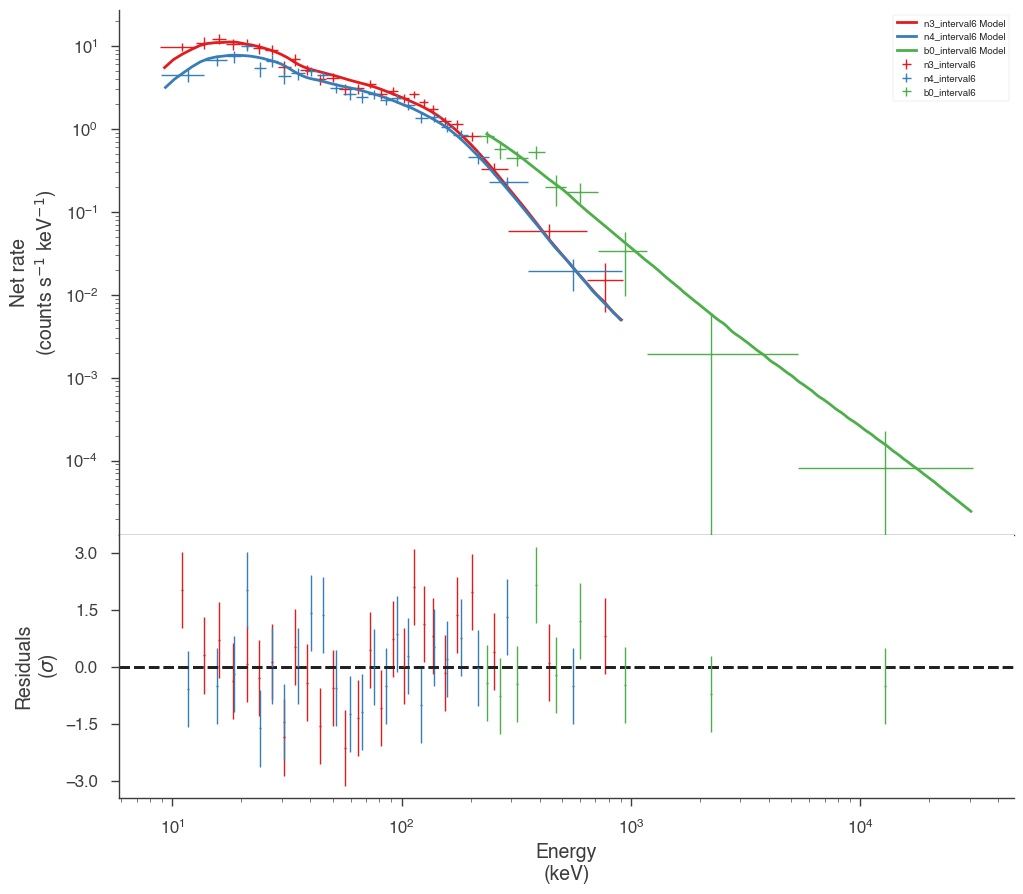

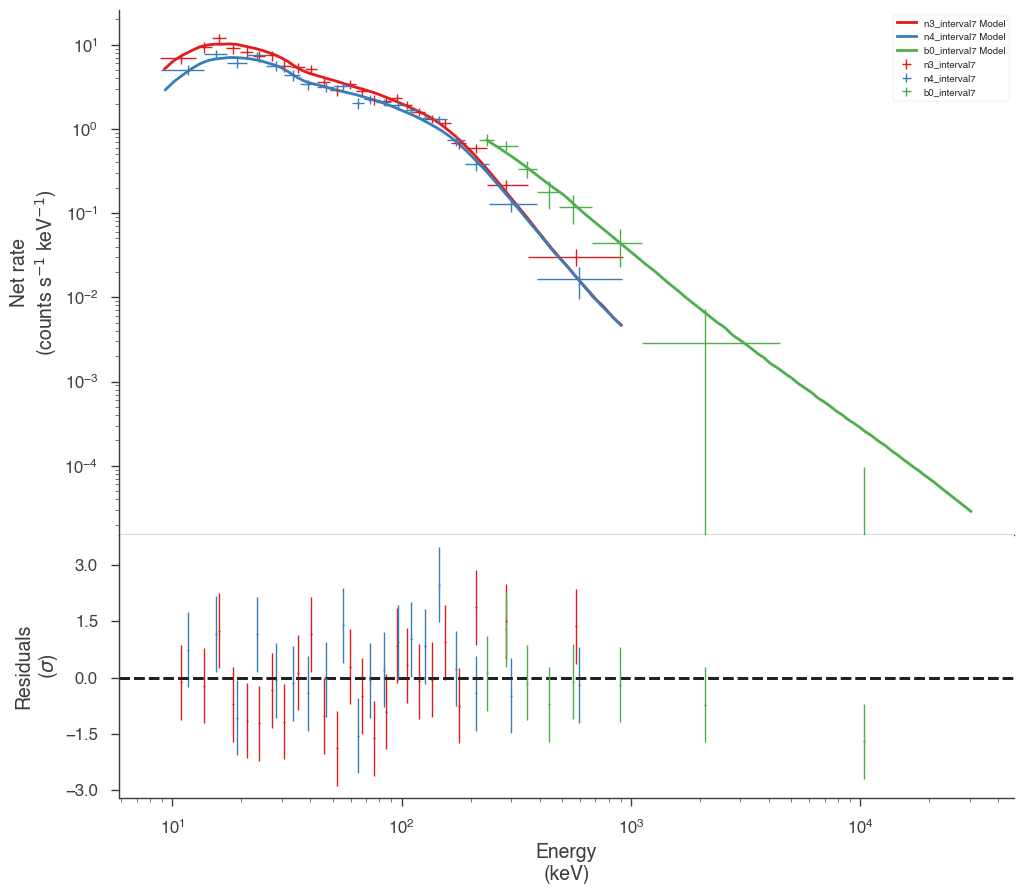

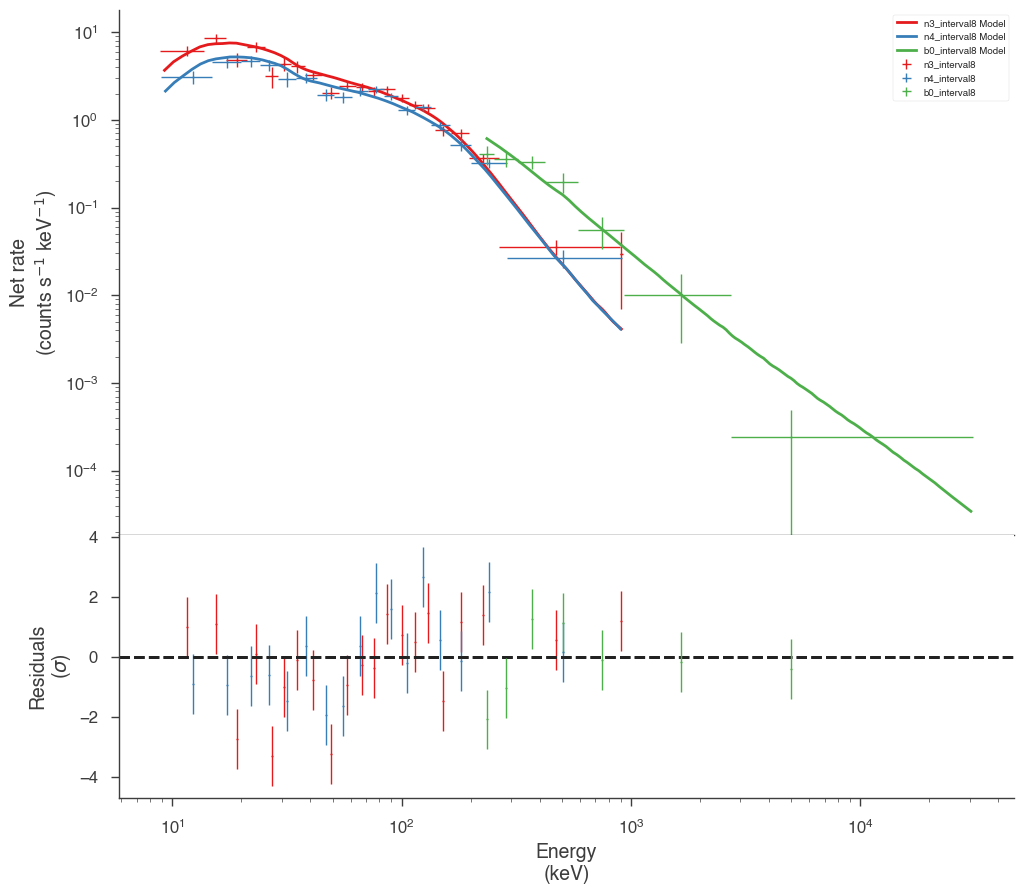

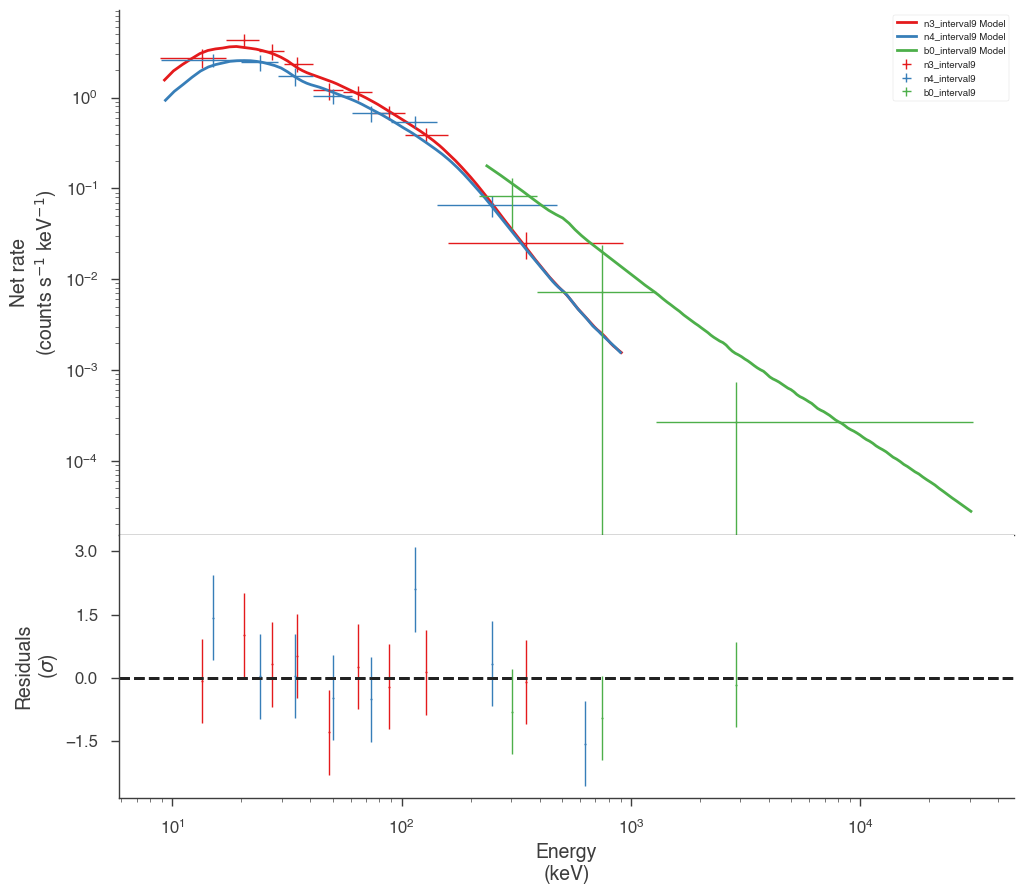

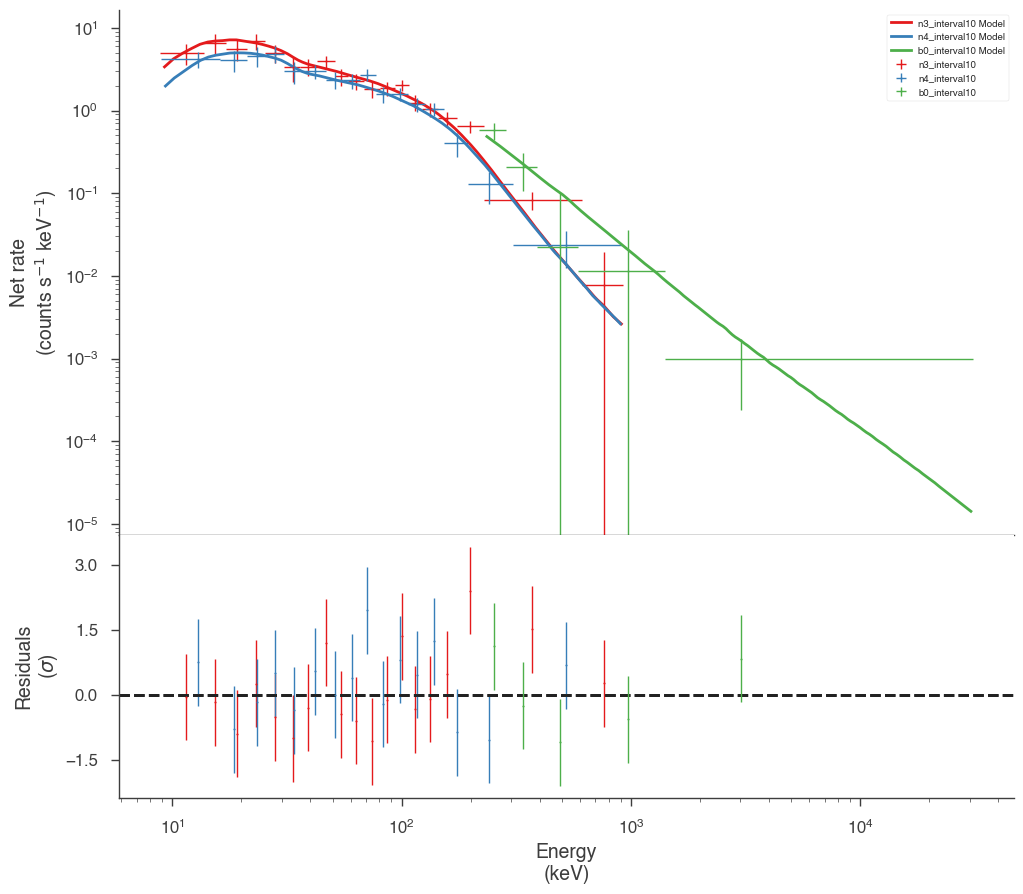

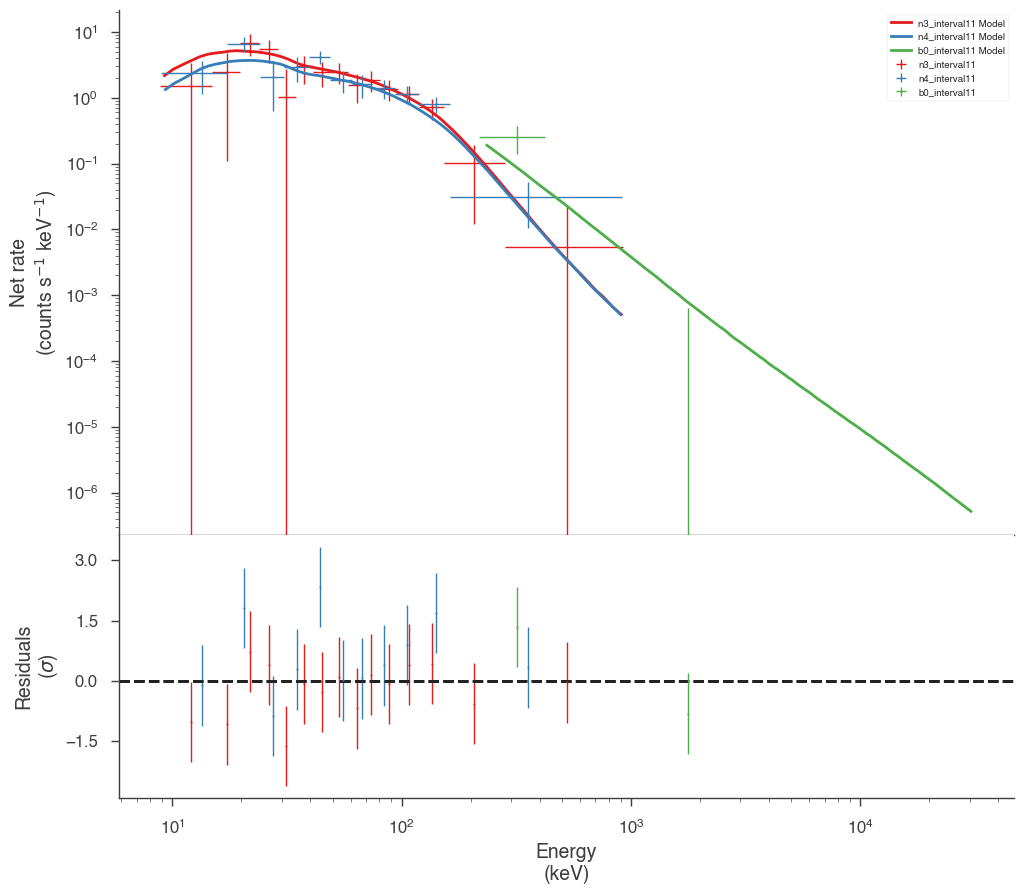

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

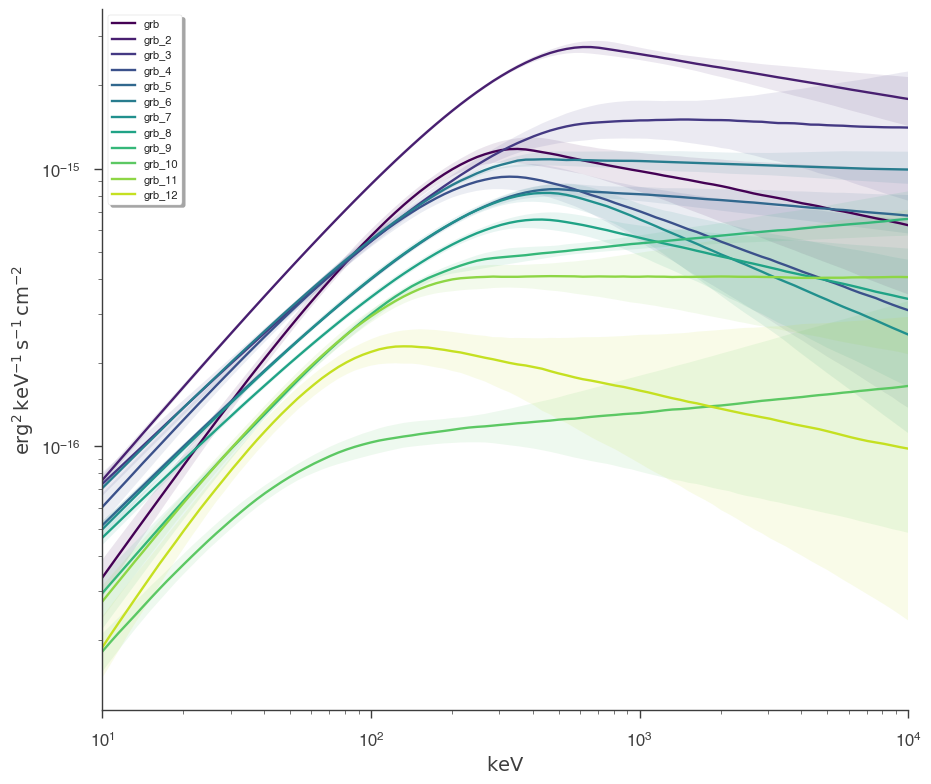

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.